In [30]:
import os
os.environ["OMP_NUM_THREADS"]='1'
import osmnx as ox
import networkx as nx
from datetime import datetime

import pandas as pd
import geopandas as gpd

from pyproj import Transformer 
import numpy as np
import scipy
from descartes import PolygonPatch

import matplotlib.pyplot as plt
from matplotlib import *
from matplotlib.patches import *
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

import contextily as ctx #Copyright (c) 2016, Dani Arribas-Bel. All rights reserved.

import math
import itertools
from shapely.geometry import MultiPolygon, Polygon, Point, LineString
from shapely.ops import nearest_points
from IPython.display import Image, IFrame

from sklearn import cluster
from sklearn.cluster import KMeans


import pandapower as pp
import pandapower.timeseries as ts
import pandapower.control as control
from pandapower.plotting import simple_plot, simple_plotly, pf_res_plotly 

from shapely import wkt


In [31]:

#Polygon als GeoDataFrame
polygon = gpd.read_file(r"./Layer/stuttgart.shp")
#Polygon als Polygon-Objekt
new_poly = polygon["geometry"].iloc[0]

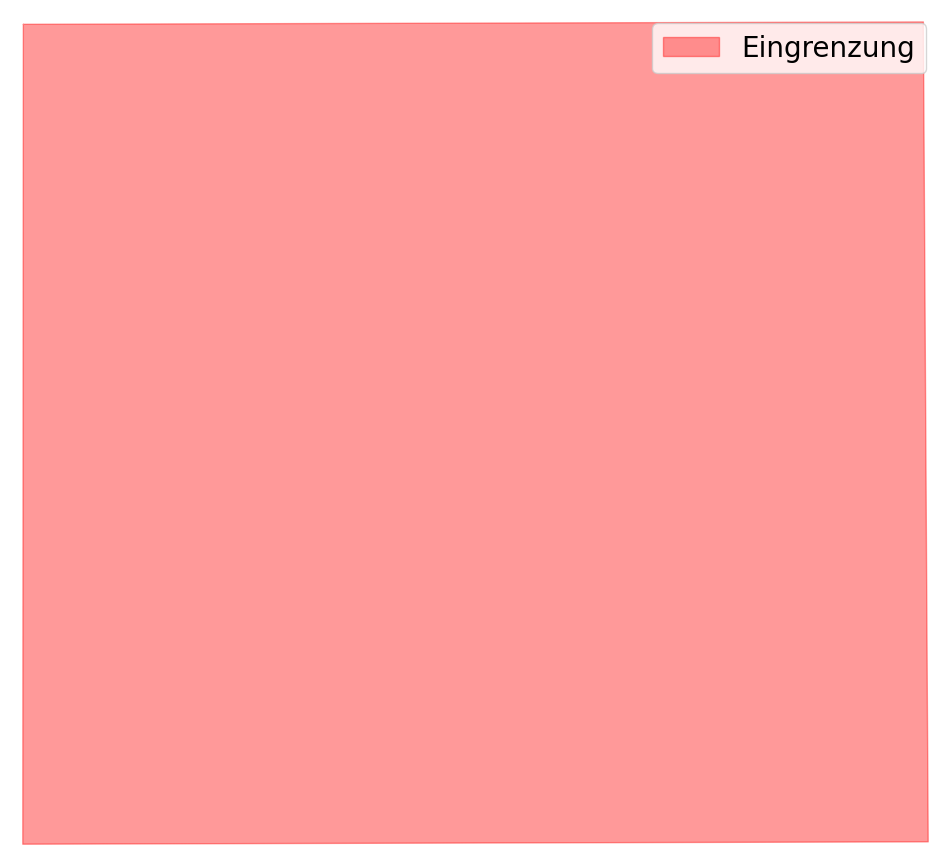

In [32]:
# PLOT DER EINGRENZUNG

#Konvertierung in metrisches System
poly_draw = polygon.to_crs(epsg=25832)
# geometrische Form des Polygons
polygon_geometry = poly_draw.unary_union
#Min & Max x,y werte des Polygons
min_x, min_y, max_x, max_y = polygon_geometry.bounds

zoom_factor = 500
#neue Eingrenzungen des Plots
new_min_x = min_x-zoom_factor
new_max_x = max_x+zoom_factor
new_min_y = min_y-zoom_factor
new_max_y = max_y+zoom_factor

fig, ax=plt.subplots(1, figsize=(12,15))
poly_draw.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.4)

ax.set_axis_off()

ax.set_xlim(new_min_x, new_max_x)
ax.set_ylim(new_min_y, new_max_y)

legend_elements= [Patch(edgecolor='red', facecolor='red', alpha =0.4, label='Eingrenzung')]
ax.legend(handles=legend_elements, loc='upper right', fontsize=20)

#cx.add_basemap(ax=ax, crs=poly_draw.crs)


#plt.savefig(r'H:\Studium\7_Semester\BA\BA Schreiben\Bilder\eingrenzung_ind.svg', format='svg', bbox_inches='tight')

#plt.show()

In [33]:
power = ox.features.features_from_polygon(new_poly, tags={"power":"transformer"})
power.crs = "EPSG:4326"
#fig, ax=plt.subplots(1, figsize=(12,15))
#power.plot(ax=ax, edgecolor='red', facecolor='red', alpha=1)

#plt.show()

In [34]:
power = power.filter(['geometry','power','phases','voltage:primary', 'voltage:secondary','voltage-high', 'voltage-low', axis=='columns'])
power['voltage:primary'] = power['voltage:primary'].combine_first(power['voltage-high'])
power['voltage:secondary'] = power['voltage:secondary'].combine_first(power['voltage-low'])
power = power.filter(['geometry','power','phases','voltage:primary', 'voltage:secondary', axis=='columns'])

HS_MS = power.loc[power['voltage:primary'].isin(['380000', '220000', '110000'])]
MS_NS = power.loc[power['voltage:primary'].isin(['100000', '20000'])]
unbekannt = power.loc[power['voltage:primary'] == 'NaN']


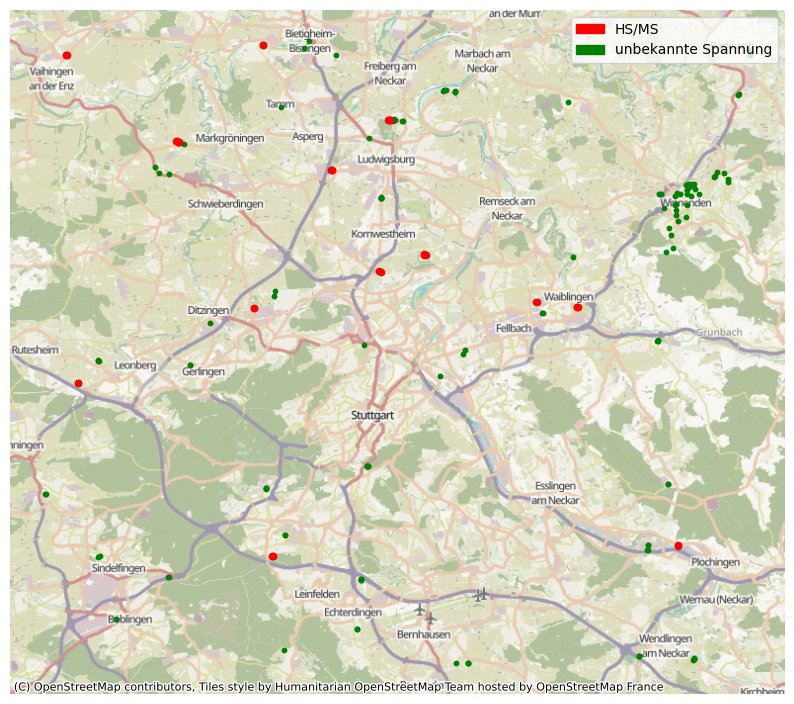

In [41]:
HS_MS = HS_MS.to_crs(epsg=3857)
MS_NS = MS_NS.to_crs(epsg=3857)
power = power.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
power.plot(ax=ax, color='green', markersize=10)
HS_MS.plot(ax=ax, color='red', markersize=20)

legend_elements = [
    Patch(color='red', label='HS/MS'),
    Patch(color='green', label='unbekannte Spannung')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
# Füge den Hintergrund von OSM hinzu
ctx.add_basemap(ax, crs=HS_MS.crs.to_string())
ax.set_axis_off()
# Zeige die Karte
plt.savefig(r'./Daten/Trafos_um_Stuttgart.png', format='png', bbox_inches='tight')
plt.show()

path = './Daten/Trafos_um_Stuttgart.xlsx'
power.to_excel(path)